In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pickle

from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns


from mcp_us_airline.utils import airport_utils
from mcp_us_airline.utils import constants
from mcp_us_airline.utils import demand_utils
from mcp_us_airline.utils import io_utils
from mcp_us_airline.utils import population_utils
from mcp_us_airline.utils import preprocess_utils


/tmp/ipykernel_3164611/3318551642.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
def collect_mcp_results(data):
    
    field_mappings = {
        'demand': 1,
        'supply': (0, 1),
        'seats': 2,
        'distance': 3,
        'time': 4,
        'flights': 6
    }

    # data = io_utils.read_data_file(fname)
    results = {field: [] for field in field_mappings.keys()}

    for row in tqdm(data):
        for field, idx in field_mappings.items():
                if isinstance(idx, tuple):
                    value = row[idx[0]] / row[idx[1]]
                else:
                    value = row[idx]
                results[field].append(value)
    return results

def collect_itinerary_costs(data):
    '''
    collect the number of flights, distance, time, and seats for each itinerary
    '''
    itinerary_flights = []
    itinerary_distance = []
    itinerary_time = []
    itinerary_seats = []

    for row in data:
        itinerary_flights.append(len(row[-1]))
        itinerary_distance.append(row[3])
        itinerary_time.append(row[4])
        itinerary_seats.append(row[5])

    return itinerary_flights, itinerary_distance, itinerary_time, itinerary_seats

def collect_flight_carrier_counts(data, flight_info, normalize=False):
    flight_counts = {}
    carrier_counts = {}

    for row in data:
        list_of_flights = row[-1]
        set_of_carriers = set()
        
        for flight in list_of_flights:
            carrier = flight_info[flight]['carrier']
            set_of_carriers.add(carrier)
        
        number_of_carriers = len(set_of_carriers)
        number_of_flights = len(list_of_flights)

        if number_of_carriers not in carrier_counts:
            carrier_counts[number_of_carriers] = 1
        else:
            carrier_counts[number_of_carriers] += 1

        if number_of_flights not in flight_counts:
            flight_counts[number_of_flights] = 1
        else:
            flight_counts[number_of_flights] += 1

    if normalize:
        total_number_of_itineraries = len(data)
        flight_counts = {k: v / total_number_of_itineraries for k, v in flight_counts.items()}
        carrier_counts = {k: v / total_number_of_itineraries for k, v in carrier_counts.items()}

        
    return flight_counts, carrier_counts


def sort_flight_legs(flight):
    list1, list2 = [], []
    # print(flight)
    for i in range(0, len(flight)):
        list1.append(flight[i][-1])  # sequence of flight
        # list2.append([flight[i][0], flight[i][1], flight[i][2], flight[i][3], flight[i][4]])
        list2.append([flight[i][j] for j in range(len(flight[i]))])
    list1, list2 = zip(*sorted(zip(list1, list2)))
    return list2 

def get_sorted_db1b_data(db1b_df, remove_outlier=False):

    if not remove_outlier and airport_coords is None:
        raise ValueError('airport_coords must be provided if remove_outlier is False')

    unique_markets = db1b_df['MktID'].unique()
    markets = {}

    for uni_market in unique_markets:
        markets[uni_market] = []

    print('dataframe to list of itineraries')
    for row in tqdm(db1b_df.itertuples(index=False), total=len(db1b_df)):
        mktid = row.MktID
        origin = row.Origin
        destination = row.Dest
        passengers = row.Passengers
        distance = row.Distance * 1.60934  # mile to km
        carrier = row.OpCarrier
        seq = row.SeqNum

        markets[mktid].append([origin, destination, int(passengers), distance, carrier, seq])

    print('sorting itineraries')
    for mktid in tqdm(markets, total=len(markets)):
        if len(markets[mktid]) > 1:
            markets[mktid] = sort_flight_legs(markets[mktid])

    if remove_outlier:
        '''
        remove directional markets that contain flights outside of the contiguous US
        '''
        contiguous_us_y_bound = (-130, -60)
        contiguous_us_x_bound = (20, 50)
        airport_coords = airport_utils.read_airports_coordinates()

        mktid_to_discard = []
        print('removing directional markets outside of the contiguous US...')
        for mktid in tqdm(markets, total=len(markets)):

            for itinerary in markets[mktid]:
                origin_coords = airport_coords[itinerary[0]]
                destination_coords = airport_coords[itinerary[1]]

                if not (contiguous_us_x_bound[0] <= origin_coords[0] <= contiguous_us_x_bound[1] and 
                        contiguous_us_y_bound[0] <= origin_coords[1] <= contiguous_us_y_bound[1] and 
                        contiguous_us_x_bound[0] <= destination_coords[0] <= contiguous_us_x_bound[1] and 
                        contiguous_us_y_bound[0] <= destination_coords[1] <= contiguous_us_y_bound[1]):
                    mktid_to_discard.append(mktid)
                    break

        for mktid in mktid_to_discard:
            del markets[mktid]
            
    return markets

def collect_itinerary_statistics_from_sold_tickets(markets, normalize=False):
    flight_counts = {}
    carrier_counts = {}
    itinerary_distance = []
    total_passengers = 0

    for mktid in markets:
        set_of_carriers = set()
        distance = 0
        for itinerary in markets[mktid]:
            passengers = itinerary[2]   
            distance += itinerary[3]  # I was not summing up the distance for each itinerary... thus I changed this line from + to +=
            set_of_carriers.add(itinerary[4])
        
        total_passengers += passengers
        number_of_carriers = len(set_of_carriers)
        number_of_flights = len(markets[mktid])

        if number_of_carriers not in carrier_counts:
            carrier_counts[number_of_carriers] = passengers
        else:
            carrier_counts[number_of_carriers] += passengers

        if number_of_flights not in flight_counts:
            flight_counts[number_of_flights] = passengers
        else:
            flight_counts[number_of_flights] += passengers

        for i in range(passengers):
            itinerary_distance.append(distance)

    if normalize:
        flight_counts = {k: v / total_passengers for k, v in flight_counts.items()}
        carrier_counts = {k: v / total_passengers for k, v in carrier_counts.items()}

    return flight_counts, carrier_counts, itinerary_distance

In [3]:
RAW_DIR = constants.RAW_DIR
DERIVED_DIR = constants.DERIVED_DIR
RESULTS_DIR = constants.RESULTS_DIR
ONTIME_DIR = constants.ONTIME_DIR
DB1B_DIR = constants.DB1B_DIR
POPULATION_DIR = constants.POPULATION_DIR

YEAR = 2019
MONTH = 4
DATE = [18]
CARRIER = "all"

daily_passenger_dict = {
    'Y2023M4': 77.5*1e6/30.0,  # https://www.bts.gov/newsroom/april-2023-us-airline-traffic-data-78-same-month-last-year
    'Y2023M11': 77.7*1e6/30.0,  # https://www.bts.gov/newsroom/november-2023-us-airline-traffic-data-81-same-month-2022
    'Y2019M4': 75.3*1e6/30.0,  # https://www.bts.gov/newsroom/august-2020-us-airline-traffic-data
}

demand_type = 'DB1B'
cost_type = 'seats'
sample_idx = 1
daily_passengers = daily_passenger_dict[f'Y{YEAR}M{MONTH}']

# figure_file_name = os.path.join('../results/manuscript', 'figure2.pdf')  # this is for the main figure
figure_file_name = os.path.join('../results/manuscript', 
                                f'SM-validation-MCP-{cost_type}-{demand_type}-Y{YEAR}M{MONTH}D{DATE[0]}.pdf')

In [4]:
flights_dict = pickle.load(open(os.path.join(DERIVED_DIR, 'byproducts', f'ontime_dict_Y{YEAR}_M{MONTH}_D{DATE[0]}.pkl'), 'rb'))

In [5]:
db1b_file = f'DB1B_Coupon_{YEAR}_Q{int(MONTH / 12 * 4)+1}.csv'
db1b_file = os.path.join(DB1B_DIR, db1b_file)
db1b_df = pd.read_csv(db1b_file)

In [6]:
sorted_markets = get_sorted_db1b_data(db1b_df, remove_outlier=True)
db1b_flight_counts, db1b_carrier_counts, db1b_itinerary_distance = collect_itinerary_statistics_from_sold_tickets(sorted_markets, normalize=True)

dataframe to list of itineraries


100%|██████████| 11355397/11355397 [00:55<00:00, 204470.41it/s]


sorting itineraries


100%|██████████| 7465479/7465479 [00:14<00:00, 510611.25it/s] 


removing directional markets outside of the contiguous US...


100%|██████████| 7465479/7465479 [00:11<00:00, 641774.53it/s]


In [7]:
cooperation_label = {
    'non_coop': 'no cooperation',
    'alliance': 'partial cooperation',
    'coop': 'full cooperation'
}

mcp_results = {}
mcp_stats = {}

for coop_type in cooperation_label.keys():
    print(f'collecting results for {coop_type}...')
    
    fname = os.path.join(RESULTS_DIR,f'Y{YEAR}M{MONTH}D{DATE[0]}', f'results_{demand_type}_{coop_type}_{cost_type}_r{sample_idx}.dat')
    raw_data = io_utils.read_data_file(fname)
    data = collect_mcp_results(raw_data)
    mcp_results[coop_type] = data

    # collect stats from MCP itineraries
    mcp_stats[coop_type] = {}
    itinerary_flights, itinerary_distance, itinerary_time, itinerary_seats = collect_itinerary_costs(raw_data)
    flight_counts, carrier_counts = collect_flight_carrier_counts(raw_data, flights_dict, normalize=True)
    mcp_stats[coop_type] = {
        'flight_counts': flight_counts,
        'carrier_counts': carrier_counts,
        'itinerary_distance': itinerary_distance,
        'itinerary_flights': itinerary_flights,
        'itinerary_time': itinerary_time,
        'itinerary_seats': itinerary_seats
    }




collecting results for non_coop...


FileNotFoundError: [Errno 2] No such file or directory: '../data/results/Y2019M4D18/results_DB1B_non_coop_seats_r1.dat'

In [63]:

def my_font_size():
    return {
        'panel_fontsize': 30,
        'main_fontsize': 25,
        'legend_fontsize': 16,
        'inset_fontsize': 16
    }

def my_line_width():
    return 3.

def my_color_dict():
    return {
        'non_coop': 'tab:blue',
        'alliance': 'tab:orange',
        'coop': 'tab:purple',
        'real_data': 'black'
    }

def my_line_style_dict():
    return {
        'non_coop': '-',
        'alliance': '--',
        'coop': ':',
        'real_data': '-.'
    }

def plot_figure2(data, fname):

    mcp_results = data[0]
    mcp_stats = data[1]
    db1b_flight_counts = data[2]
    db1b_carrier_counts = data[3]
    db1b_itinerary_distance = data[4]
    daily_passengers = data[5]

    panel_fontsize = my_font_size()['panel_fontsize']
    main_fontsize = my_font_size()['main_fontsize']
    legend_fontsize = my_font_size()['legend_fontsize']
    inset_fontsize = my_font_size()['inset_fontsize']

    lw = my_line_width()

    color_dict = my_color_dict()
    ls_dict = my_line_style_dict()
    

    fig, ax = plt.subplots(ncols=2, nrows=2,figsize=(16, 12))


    # panel (a)

    ax[0][0].plot(mcp_results['non_coop']['demand'], 
                mcp_results['non_coop']['supply'],
                lw=lw,
                color=color_dict['non_coop'],
                linestyle=ls_dict['non_coop'],
                label=cooperation_label['non_coop'])

    ax[0][0].plot(mcp_results['alliance']['demand'], 
                mcp_results['alliance']['supply'],
                lw=lw,
                color=color_dict['alliance'],
                linestyle=ls_dict['alliance'],
                label=cooperation_label['alliance'])

    ax[0][0].plot(mcp_results['coop']['demand'], 
                mcp_results['coop']['supply'],
                lw=lw,
                color=color_dict['coop'],
                linestyle=ls_dict['coop'],    
                label=cooperation_label['coop'])

    ax[0][0].axvline(daily_passengers, color=color_dict['real_data'], linestyle=ls_dict['real_data'], label='real data', lw=lw)

    ax[0][0].legend(loc='lower left', fontsize=legend_fontsize)
    ax[0][0].set_xlabel('demanded itineraries', fontsize=main_fontsize)
    ax[0][0].set_ylabel('supplied itineraries', fontsize=main_fontsize)
    ax[0][0].tick_params('both', labelsize=main_fontsize)
    ax[0][0].set_xscale('log')
    ax[0][0].set_xlim(5e3, 5e8)
    ax[0][0].set_ylim(-0.02, 1.02)

    # panel (b)

    ax[0][1].plot(mcp_results['non_coop']['demand'], 
                mcp_results['non_coop']['seats'],
                lw=lw,
                color=color_dict['non_coop'],
                linestyle=ls_dict['non_coop'],
                label=cooperation_label['non_coop'])

    ax[0][1].plot(mcp_results['alliance']['demand'], 
                mcp_results['alliance']['seats'],
                lw=lw,
                color=color_dict['alliance'],
                linestyle=ls_dict['alliance'],
                label=cooperation_label['alliance'])

    ax[0][1].plot(mcp_results['coop']['demand'], 
                mcp_results['coop']['seats'],
                lw=lw,
                color=color_dict['coop'],
                linestyle=ls_dict['coop'],
                label=cooperation_label['coop'])

    ax[0][1].axvline(daily_passengers, color=color_dict['real_data'], linestyle=ls_dict['real_data'], lw=lw)

    ax[0][1].set_xlabel('demanded itineraries', fontsize=main_fontsize)
    ax[0][1].set_ylabel('remaining seats', fontsize=main_fontsize)
    ax[0][1].tick_params('both', labelsize=main_fontsize)
    ax[0][1].set_xscale('log')
    ax[0][1].set_xlim(5e3, 5e8)
    ax[0][1].set_ylim(-0.02, 1.02)


    # panel (c)

    # Filter to only include keys 1-3
    x_values = [1, 2, 3]

    # Plot bars side by side instead of stacked
    bar_width = 0.2
    x_positions = np.arange(len(x_values))

    # Plot non_coop bars
    non_coop_values = [mcp_stats['non_coop']['carrier_counts'].get(x, 0) for x in x_values]
    ax[1][0].bar(x_positions - 1.5*bar_width, non_coop_values, bar_width, 
                color=color_dict['non_coop'],
                linestyle=ls_dict['non_coop'],
                label=cooperation_label['non_coop'])

    # Plot alliance bars
    alliance_values = [mcp_stats['alliance']['carrier_counts'].get(x, 0) for x in x_values]
    ax[1][0].bar(x_positions - 0.5*bar_width, alliance_values, bar_width,
                color=color_dict['alliance'],
                linestyle=ls_dict['alliance'],
                label=cooperation_label['alliance'])

    # Plot coop bars  
    coop_values = [mcp_stats['coop']['carrier_counts'].get(x, 0) for x in x_values]
    ax[1][0].bar(x_positions + 0.5*bar_width, coop_values, bar_width,
                color=color_dict['coop'],
                linestyle=ls_dict['coop'],
                label=cooperation_label['coop'])

    # Plot real data bars
    real_values = [db1b_carrier_counts.get(x, 0) for x in x_values]
    ax[1][0].bar(x_positions + 1.5*bar_width, real_values, bar_width,
                color=color_dict['real_data'],
                linestyle=ls_dict['real_data'],
                label='real data')

    ax[1][0].set_xticks(x_positions)
    ax[1][0].set_xticklabels(x_values)
    ax[1][0].set_xlabel('number of carriers', fontsize=main_fontsize)
    ax[1][0].set_ylabel('probability distribution', fontsize=main_fontsize)
    ax[1][0].tick_params('both', labelsize=main_fontsize)
    # ax[1][0].legend()

    # inset of panel (c)

    axinset = ax[1][0].inset_axes([0.5, 0.3, 0.4, 0.4])
    # Filter to only include keys 1-4 for flight counts
    x_values_inset = [1, 2, 3]
    x_positions_inset = np.arange(len(x_values_inset))

    # Plot bars side by side
    bar_width_inset = 0.2

    # Plot non_coop bars
    non_coop_values_inset = [mcp_stats['non_coop']['flight_counts'].get(x, 0) for x in x_values_inset]
    axinset.bar(x_positions_inset - 1.5*bar_width_inset, non_coop_values_inset, bar_width_inset,
                color=color_dict['non_coop'],
                linestyle=ls_dict['non_coop'])

    # Plot alliance bars
    alliance_values_inset = [mcp_stats['alliance']['flight_counts'].get(x, 0) for x in x_values_inset]
    axinset.bar(x_positions_inset - 0.5*bar_width_inset, alliance_values_inset, bar_width_inset,
                color=color_dict['alliance'],
                linestyle=ls_dict['alliance'])

    # Plot coop bars
    coop_values_inset = [mcp_stats['coop']['flight_counts'].get(x, 0) for x in x_values_inset]
    axinset.bar(x_positions_inset + 0.5*bar_width_inset, coop_values_inset, bar_width_inset,
                color=color_dict['coop'],
                linestyle=ls_dict['coop'])

    # Plot real data bars
    real_values_inset = [db1b_flight_counts.get(x, 0) for x in x_values_inset]
    axinset.bar(x_positions_inset + 1.5*bar_width_inset, real_values_inset, bar_width_inset,
                color=color_dict['real_data'],
                linestyle=ls_dict['real_data'])

    axinset.set_xticks(x_positions_inset)
    axinset.set_xticklabels(x_values_inset)
    axinset.set_xlabel('number of flights', fontsize=inset_fontsize)
    axinset.set_ylabel(' ', fontsize=inset_fontsize)
    axinset.tick_params('both', labelsize=inset_fontsize)
    axinset.set_ylim(0., 1.)




    # panel (d)
    bins=30
    # Define common bin range from 0 to 10000 (matching the xlim set below)
    bin_range = (
        min([
            min(mcp_stats['non_coop']['itinerary_distance']),
            min(mcp_stats['alliance']['itinerary_distance']), 
            min(mcp_stats['coop']['itinerary_distance']),
            min(db1b_itinerary_distance)]),
        max([
            max(mcp_stats['non_coop']['itinerary_distance']),
            max(mcp_stats['alliance']['itinerary_distance']), 
            max(mcp_stats['coop']['itinerary_distance']),
            max(db1b_itinerary_distance)])
    )
    
    sns.histplot(mcp_stats['non_coop']['itinerary_distance'], 
                bins=bins,
                binrange=bin_range,
                stat='density',
                element='step', 
                fill=False,
                lw=lw,
                color=color_dict['non_coop'],
                linestyle=ls_dict['non_coop'],
                ax=ax[1][1],
                label=cooperation_label['non_coop'])
    sns.histplot(mcp_stats['alliance']['itinerary_distance'],
                bins=bins,
                binrange=bin_range, 
                stat='density',
                element='step',
                fill=False,
                lw=lw,
                color=color_dict['alliance'],
                linestyle=ls_dict['alliance'],
                ax=ax[1][1],
                label=cooperation_label['alliance'])
    sns.histplot(mcp_stats['coop']['itinerary_distance'],
                bins=bins,
                binrange=bin_range,
                stat='density', 
                element='step',
                fill=False,
                lw=lw,
                color=color_dict['coop'],
                linestyle=ls_dict['coop'],
                ax=ax[1][1],
                label=cooperation_label['coop'])
    sns.histplot(db1b_itinerary_distance,
                bins=bins,
                binrange=bin_range,
                stat='density',
                element='step',
                fill=False,
                lw=lw,
                color=color_dict['real_data'],
                linestyle=ls_dict['real_data'],
                ax=ax[1][1],
                label='real data')

    ax[1][1].set_xlabel('itinerary length', fontsize=main_fontsize)
    ax[1][1].set_ylabel('probability distribution', fontsize=main_fontsize)
    ax[1][1].tick_params('both', labelsize=main_fontsize)
    ax[1][1].set_xlim(0, 6000)
    ax[1][1].set_ylim(0, 0.0006)
    
    # Set x-ticks in terms of thousands
    # xticks = np.arange(0, 6001, 2000)
    # ax[1][1].set_xticks(xticks)
    # ax[1][1].set_xticklabels([f'${x/1000:.0f}\\times 10^3$' for x in xticks])
    
    # yticks = np.arange(0, 0.0008, 0.0002) 
    # ax[1][1].set_yticks(yticks)
    # ax[1][1].set_yticklabels([f'${y*10000:.0f}\\times 10^{{-4}}$' for y in yticks])

    ##### misc. #####

    ax[0][0].text(0.9, 0.88, '(a)', 
                transform=ax[0][0].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[0][1].text(0.9, 0.88, '(b)', 
                transform=ax[0][1].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[1][0].text(0.9, 0.88, '(c)', 
                transform=ax[1][0].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
    ax[1][1].text(0.9, 0.88, '(d)', 
                transform=ax[1][1].transAxes, 
                fontsize=panel_fontsize, ha='center', va='center')
                

    plt.tight_layout()
    plt.savefig(fname, bbox_inches='tight', format='pdf')
    plt.show()

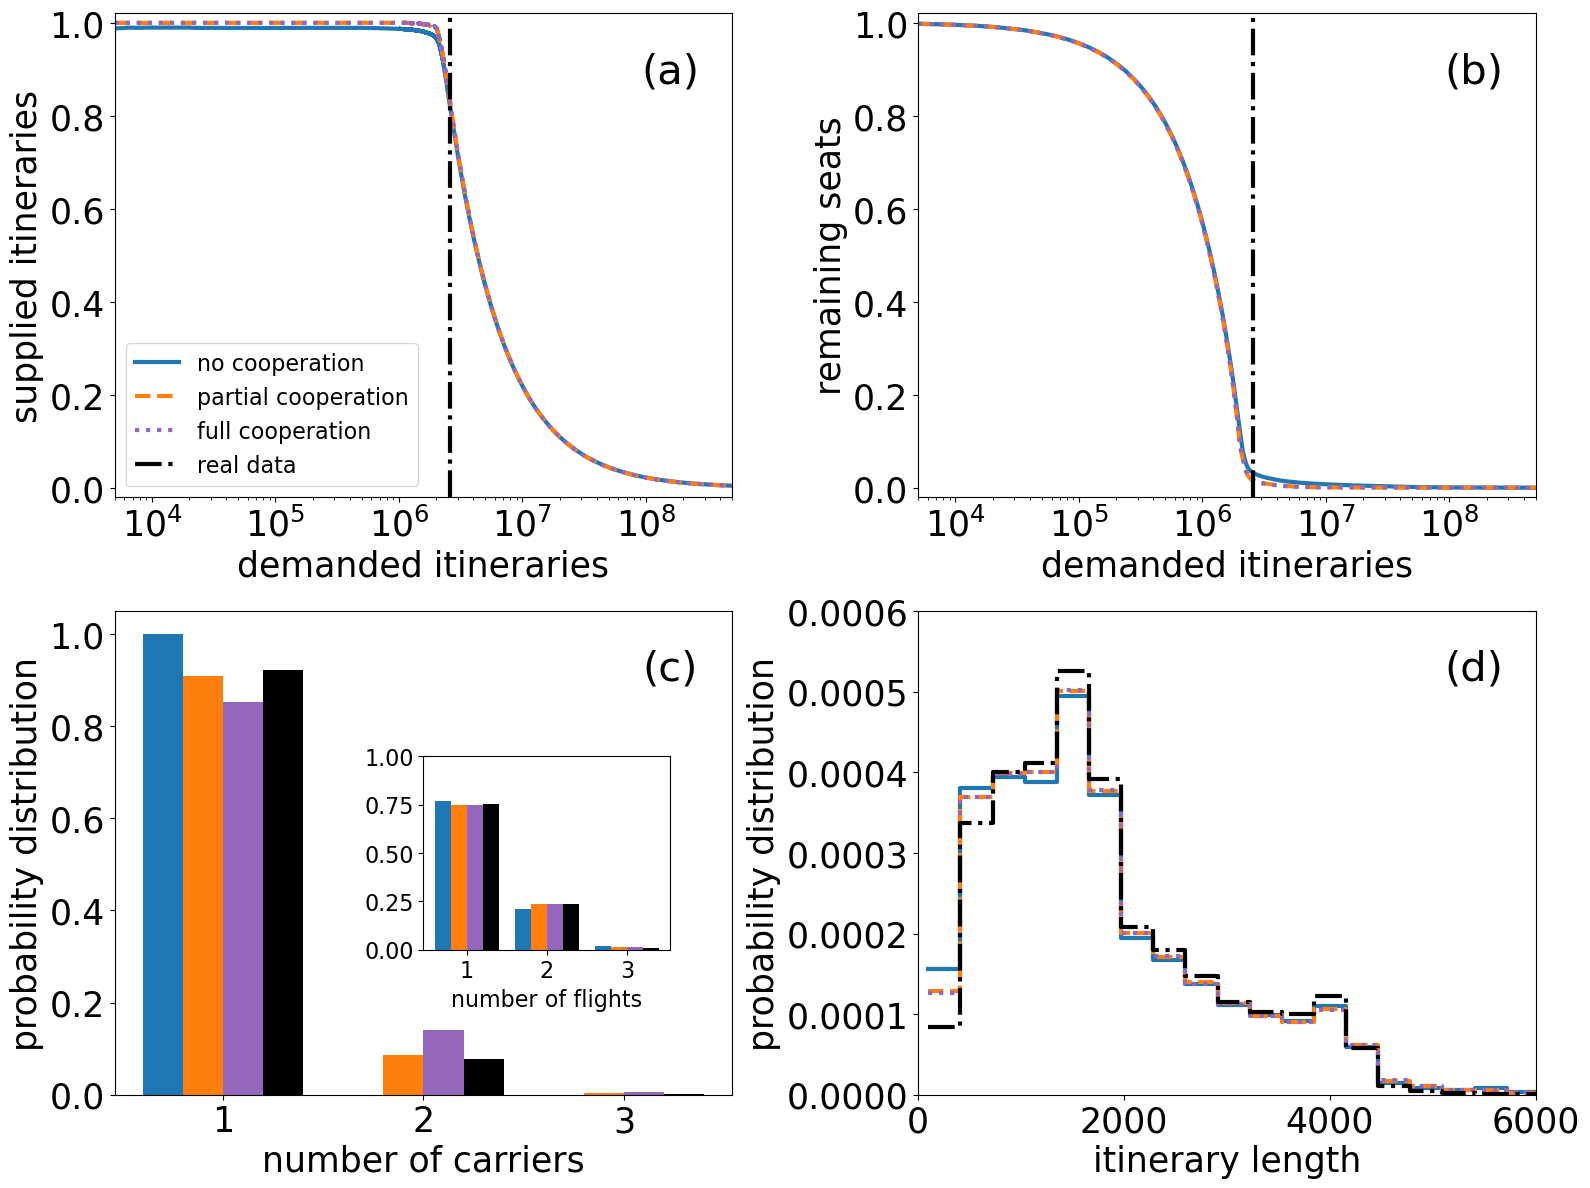

In [64]:
data = [mcp_results, 
        mcp_stats, 
        db1b_flight_counts, 
        db1b_carrier_counts, 
        db1b_itinerary_distance, 
        daily_passengers]

plot_figure2(data, figure_file_name)

In [60]:
figure_file_name

'../results/manuscript/SM-validation-MCP-time-DB1B-Y2023M4D18.pdf'

# Figure with additional FCN parameters